## _*Quantum SVM (variational method)*_

The QSVMKernel notebook here demonstrates a kernel based approach. This notebook shows a variational method.

For further information please see: [https://arxiv.org/pdf/1804.11326.pdf](https://arxiv.org/pdf/1804.11326.pdf)


**This notebook shows the SVM implementation based on the variational method.**

In this file, we show two ways for using the quantum variational method: (1) the non-programming way and (2) the programming way. 


### Part I: non-programming way.
In the non-programming way, we config a json-like configuration, which defines how the svm instance is internally constructed. After the execution, it returns the json-like output, which carries the important information (e.g., the details of the svm instance) and the processed results. 

In [2]:
from datasets import *
from qiskit_aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit import Aer
from qiskit_aqua.input import SVMInput
from qiskit_aqua import run_algorithm, QuantumInstance
from qiskit_aqua.algorithms import QSVMVariational
from qiskit_aqua.components.optimizers import SPSA
from qiskit_aqua.components.feature_maps import SecondOrderExpansion
from qiskit_aqua.components.variational_forms import RYRZ

First we prepare the dataset, which is used for training, testing and the finally prediction.

*Note: You can easily switch to a different dataset, such as the Breast Cancer dataset, by replacing 'ad_hoc_data' to 'Breast_cancer' below.*

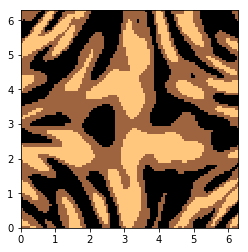

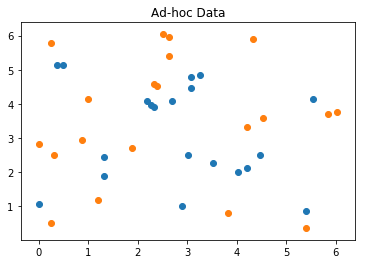

{'A': 0, 'B': 1}


In [3]:
feature_dim = 2 # dimension of each data point
training_dataset_size = 20
testing_dataset_size = 10
random_seed = 10598
shots = 1024

sample_Total, training_input, test_input, class_labels = ad_hoc_data(training_size=training_dataset_size, 
                                                                     test_size=testing_dataset_size, 
                                                                     n=feature_dim, gap=0.3, PLOT_DATA=True)

datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
print(class_to_label)

Now we create the svm in the non-programming way.
In the following json, we config:
- the algorithm name 
- the variational form
- the feature map 
- the optimizer

In [4]:
params = {
    'problem': {'name': 'svm_classification', 'random_seed': 10598},
    'algorithm': {'name': 'QSVM.Variational', 'override_SPSA_params': True},
    'backend': {'shots': 1024},
    'optimizer': {'name': 'SPSA', 'max_trials': 200, 'save_steps': 1},
    'variational_form': {'name': 'RYRZ', 'depth': 3},
    'feature_map': {'name': 'SecondOrderExpansion', 'depth': 2}
}

svm_input = SVMInput(training_input, test_input, datapoints[0])
backend = Aer.get_backend('qasm_simulator')

With everything setup, we can now run the algorithm.

For the testing, the result includes the details and the success ratio.

For the prediction, the result includes the predicted labels. 

In [5]:
result = run_algorithm(params, svm_input, backend=backend)
print("testing success ratio: ", result['testing_accuracy'])
print("predicted classes:", result['predicted_classes'])

testing success ratio:  1.0
predicted classes: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']


### Part II: programming way.
We construct the svm instance directly from the classes. The programming way offers the users better accessibility, e.g., the users can access the internal state of svm instance or invoke the methods of the instance. 

Now we create the svm in the programming way.
- we build the optimizer instance (required by the svm instance) by instantiating the class SPSA.
- We build the feature map instance (required by the svm instance) by instantiating the class SecondOrderExpansion.
- We build the varitional form instance (required by the svm instance) by instantiating the class RYRZ.
- We build the svm instance by instantiating the class QSVMVariational. 


In [6]:
backend = Aer.get_backend('qasm_simulator')
optimizer = SPSA(max_trials=100, c0=4.0, skip_calibration=True)
optimizer.set_options(save_steps=1)
feature_map = SecondOrderExpansion(num_qubits=feature_dim, depth=2)
var_form = RYRZ(num_qubits=feature_dim, depth=3)
svm = QSVMVariational(optimizer, feature_map, var_form, training_input, test_input)
quantum_instance = QuantumInstance(backend, shots=shots, seed=random_seed, seed_mapper=random_seed)

Now we run it.

In [6]:
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  1.0


Different from the non-programming way, the programming way allows the users to invoke APIs upon the svm instance directly. In the following, we invoke the API "predict" upon the trained svm instance to predict the labels for the newly provided data input.

Use the trained model to evaluate data directly, and we store a label_to_class and class_to_label for helping converting between label and class name

In [7]:
predicted_probs, predicted_labels = svm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, svm.label_to_class)
print("prediction:   {}".format(predicted_labels))

prediction:   [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
